# Analysis

In [1]:
import os, re
from main.FolderInfos import FolderInfos
from main.src.models.ModelFactory import ModelFactory

FolderInfos.init(test_without_data=True)
list_dataout_folders = os.listdir(FolderInfos.data_folder)
list_folders = []
for f in list_dataout_folders:
    full_path = FolderInfos.data_folder+f
    files = os.listdir(full_path)
    files_to_contain = [[re.compile(r".+_parameters.json$"),False]]
    for file in files:
        for i,check in enumerate(files_to_contain):
            if check[0].match(file):
                files_to_contain[i][1] = True
        if len(list(filter(lambda x:x[1] is False,files_to_contain))) == 0: # If all of the required files are in the folder
            list_folders.append(f)
            break

import ipywidgets as widgets
for f in list_folders:
    widgets.ToggleButton(
        value=False,
        description=f,
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check' # (FontAwesome names without the `fa-` prefix)
    )
selected_folder = list_folders
import json
global_dict = {}
for f in selected_folder:
    full_path = FolderInfos.data_folder+f+FolderInfos.separator
    with open(f"{full_path}{f}parameters.json") as fp:
        global_dict[f] = json.load(fp)

C:\Anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from IPython.display import display
from ipywidgets import Checkbox, VBox, IntSlider, HBox, IntText, FloatText
import plotly.graph_objects as go
import pandas as pd
import main.src.analysis.tools as tls

def loss_access(x,mode):
    return x["training"][f"{mode}_loss"]
def metrics_access(x,name,mode):
    return x["metrics"]["attr_list_metrics"][name][f"{mode}_values"]

dico_loss = {"tr_loss":lambda x:loss_access(x,mode="tr"),"valid_loss":lambda x:loss_access(x,mode="valid")}

dico_accuracy = {"tr_accuracy_classification-0.1":lambda x:metrics_access(x,"accuracy_classification-0.1","tr"),
                 "valid_accuracy_classification-0.1":lambda x:metrics_access(x,"accuracy_classification-0.1","valid"),
                 "tr_accuracy_classification-0.25":lambda x:metrics_access(x,"accuracy_classification-0.25","tr"),
                 "valid_accuracy_classification-0.25":lambda x:metrics_access(x,"accuracy_classification-0.25","valid"),
                 }
dico_mae = {"tr_mae":lambda x:metrics_access(x,"mae","tr"),
            "valid_mae":lambda x:metrics_access(x,"mae","valid")
            }
list_access_functions = {**dico_loss,
                         **dico_accuracy,
                         **dico_mae
                         }
list_values_names_availables = []
for name,f in list_access_functions.items():
    try:
        for dico in global_dict.values():
            f(dico)
        list_values_names_availables.append(name)
    except Exception():
        pass
filters = None
log_scale = None
box = None
from IPython.display import display,clear_output
def actualize(v):
    import numpy as np
    global box
    clear_output()
    list_values_names_availables_filtered = []
    if filters is not None:
        for metric,widg in filters.items():
            if widg.value is True:
                list_values_names_availables_filtered.append(metric)
    list_values_names_availables = list_values_names_availables_filtered
    liste_values = []
    min_val,max_val = 1000000,-1000000
    max_length = 0
    for metric_name in list_values_names_availables:
        for f in global_dict.keys():
            batch_size = global_dict[f]["data"]["batch_size"] * global_dict[f]["data"]["eval_step"] if "valid" in metric_name else global_dict[f]["data"]["batch_size"]
            window = int(window_mean.value/batch_size)
            v = tls.moving_mean(list_access_functions[metric_name](global_dict[f]),window=window)
            x = np.arange(0,len(v)) * batch_size

            max_length = max(np.max(x),max_length)
            min_val = min(min_val,np.min(v[5:]))
            max_val = max(max_val,np.max(v[5:]))
            x = pd.Series(x)
            v = pd.Series(v)
            graph = go.Scatter(x=x,y=v,mode='lines',name=f"{metric_name} {f}",hovertemplate='Sample n°: %{x}'+f'<br>{metric_name}:'+' %{y}')
            liste_values.append(graph)
    # print(min_val,max_val)
    import numpy as np
    epoch_size = max(map(lambda x:x["data"]["dataset"]["attr_length_dataset"],global_dict.values()))


    fig = go.Figure(
        data=liste_values,
        layout=go.Layout(
            title=go.layout.Title(text=""),
            xaxis_title="Number of samples processed",
            yaxis_title=f"Values",
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            yaxis={'tickformat':'.1e',

                   },


        )
    )
    if log_scale is not None and log_scale.value is True:
        fig.update_yaxes(type="log")
    fig.show()
    if box is not None:
        display(box)
    return min_val,max_val

window_mean = IntText(
    value=100,
    description='Mean window:',
    disabled=False
)
mini,maxi = actualize(None)
clear_output()
log_scale = Checkbox(False,description="y_log")
filters = {name:Checkbox(False,description=name) for name in list_values_names_availables}
list_widgets = [*filters.values(),log_scale,window_mean]
box1 = VBox(list(filters.values()))
box = HBox([box1,VBox([log_scale,window_mean])])







for w in list_widgets:
    w.observe(actualize)
box

In [3]:
from ipywidgets import Dropdown

choice_folder = Dropdown(
    options=selected_folder,
    value=selected_folder[0],
    description='Folder to vizualize result',
    disabled=False,
         )
display(choice_folder)

Dropdown(description='Folder to vizualize result', options=('2021-06-10_11h31min34s_', '2021-06-11_12h30min51s…

Output()

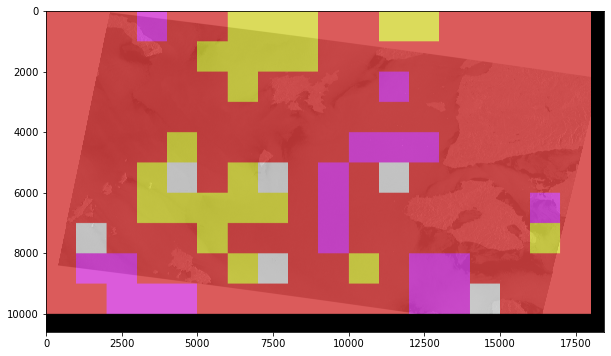

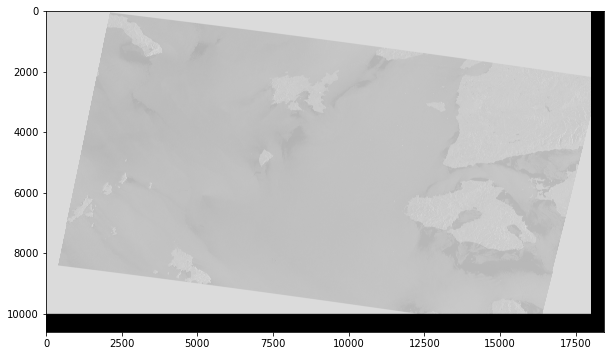

In [4]:
choice_folder = choice_folder.value
from main.src.models.ModelFactory import ModelFactory
from main.src.analysis.tools import RGB_Overlay_Patch
import json
FolderInfos.init(test_without_data=True)
folder = FolderInfos.data_folder + choice_folder + FolderInfos.separator
with open(folder + choice_folder + "parameters.json", "r") as fp:
    dico = json.load(fp)

rgb_overlay = RGB_Overlay_Patch(usage_type="classification", patch_creator="fixed_px",
                            grid_size=dico["data"]["dataset"]["attr_patch_creator"]["attr_grid_size_px"],
                            input_size=dico["data"]["dataset"]["attr_dataset"]["attr_resizer"][
                                "attr_out_size_w"])
epoch = 0
iteration = 6080
import torch

device = torch.device("cuda")
model = ModelFactory(model_name=dico["model"]["attr_model_name"], num_classes=dico["model"]["attr_num_classes"])()
model.to(device)
model.load_state_dict(torch.load(f"{folder}{choice_folder}_model_epoch-{epoch}_it-{iteration}.pt"))
array_overlay = rgb_overlay(name_img="027481_0319CB_0EB7", model=model, blending_factor=0.5, device=device)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(array_overlay[0])
plt.figure(figsize=(10,10))
plt.imshow(array_overlay[1])